## Podział zbiorów danych

Każdy ze zbiorów danych podzielić na dwie równe części: uczącą i testującą

In [53]:
from generating_data import generate_checkerboard, generate_data

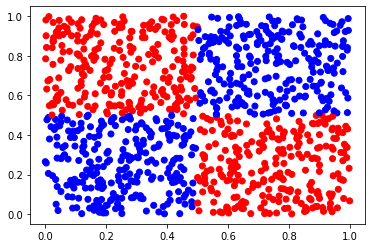

In [54]:
x, y = generate_checkerboard(n_size=3, n_samples=1000)

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import timeit
import pandas as pd

experiment_data = []

n_dimensions_experiments = [2, 3, 10]
n_samples_experiments = [200, 400]

for n_dimensions in n_dimensions_experiments:
    for n_samples in n_samples_experiments:
        X, y, _ = generate_data(n_dimension=n_dimensions, n_samples=n_samples, noise=False)

        # test, train split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

        # parameters
        algorithms = ['ball_tree', 'kd_tree', 'brute']
        leaf_sizes = [2, 30, 100]
        n_neighbors = [3, 7, 9, 27, 65]

        # fitting algorithms and caculating score
        for a in algorithms:
            for l in leaf_sizes:
                for n in n_neighbors:
                    knn = KNeighborsClassifier(n_neighbors=n, leaf_size=l, algorithm=a)
                    time_fit_start = timeit.timeit()
                    knn.fit(X_train, y_train)
                    time_fit_end = timeit.timeit()
                    time_fit = time_fit_end - time_fit_start

                    time_predict_start = timeit.timeit()
                    knn.score(X_test, y_test)
                    time_predict_end = timeit.timeit()
                    time_predict = time_predict_end - time_fit_start
                    experiment_data.append([n, l, a, time_predict, time_predict])
            
df = pd.DataFrame(experiment_data, columns = ['n_neigbors', 'leaf_size', 'algorithm', 'time_fit', 'time_predict'])
df

,n_neigbors,leaf_size,algorithm,time_fit,time_predict
0,3,2,ball_tree,0.002473,0.002473
1,7,2,ball_tree,-0.003877,-0.003877
2,9,2,ball_tree,-0.000382,-0.000382
3,27,2,ball_tree,-0.000315,-0.000315
4,65,2,ball_tree,0.000126,0.000126
...,...,...,...,...,...
265,3,100,brute,0.000091,0.000091
266,7,100,brute,0.000493,0.000493
267,9,100,brute,0.000204,0.000204
268,27,100,brute,-0.000032,-0.000032
